## 1. Import package

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import tensorflow as tf
import os
import pickle
import hashlib

## 2.Unzip the dataset

In [3]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


## 3.View movies.dat and users.dat and ratings.dat

In [4]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python',encoding="ISO-8859-1")
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python',encoding="ISO-8859-1")
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python',encoding="ISO-8859-1")
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 4.Data pre-processing

### 4.1 Data pre-processing of users.dat、movies.dat and ratings.csv

In [8]:
def read_dat():
    """
    Load Dataset from File
    """
    
    users_name = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header = None, names = users_name, engine = 'python',encoding = "ISO-8859-1")
   
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orga = users.values
   
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    
    movies_name = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names = movies_name, engine = 'python',encoding = "ISO-8859-1")
    movies_orga = movies.values
    
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_change = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_change)

    
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>')
    
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    
    genres_change = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    
    for key in genres_change:
        for cnt in range(max(genres2int.values()) - len(genres_change[key])):
            genres_change[key].insert(len(genres_change[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_change)

    
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}

    
    title_count = 15
    title_change = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_change:
        for cnt in range(title_count - len(title_change[key])):
            title_change[key].insert(len(title_change[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_change)

    
    ratings_name = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names = ratings_name, engine = 'python',encoding = "ISO-8859-1")
    ratings = ratings.filter(regex = 'UserID|MovieID|ratings')

    
    data = pd.merge(pd.merge(ratings, users), movies)
    
    
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orga, users_orga

In [9]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orga, users_orga= read_dat()

with open('./pre_process.pkl', 'wb') as f:
    pickle.dump((title_count, 
                 title_set, 
                 genres2int, 
                 features, 
                 targets_values, 
                 ratings, 
                 users, 
                 movies, 
                 data, 
                 movies_orga, 
                 users_orga), 
                f)

### 4.2 View the user, movie and rating files after  the pre-processing

In [10]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [11]:
movies.head()

,MovieID,Title,Genres
0,1,"[3060, 2743, 2545, 2545, 2545, 2545, 2545, 254...","[6, 14, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16..."
1,2,"[981, 2545, 2545, 2545, 2545, 2545, 2545, 2545...","[10, 14, 3, 16, 16, 16, 16, 16, 16, 16, 16, 16..."
2,3,"[4370, 2915, 4704, 2545, 2545, 2545, 2545, 254...","[12, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
3,4,"[1499, 4207, 2271, 2545, 2545, 2545, 2545, 254...","[12, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16..."
4,5,"[3613, 5039, 3877, 3534, 1239, 5170, 2545, 254...","[12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."


In [12]:
movies.values[0]

array([1,
       list([3060, 2743, 2545, 2545, 2545, 2545, 2545, 2545, 2545, 2545, 2545, 2545, 2545, 2545, 2545]),
       list([6, 14, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])],
      dtype=object)

### 5.Building neural networks

5.1 Define the required parameters

In [21]:
embed_dim = 32
uid_max = max(features.take(0,1)) + 1 
gender_max = max(features.take(2,1)) + 1 
age_max = max(features.take(3,1)) + 1 
job_max = max(features.take(4,1)) + 1
movie_id_max = max(features.take(1,1)) + 1 
movie_categories_max = max(genres2int.values()) + 1 
movie_title_max = len(title_set) 
combiner = "sum"
sentences_size = title_count 
window_sizes = {2, 3, 4, 5}
filter_num = 8
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}
num_epochs = 5
batch_size = 256
dropout_keep = 0.5
learning_rate = 0.0001
show_every_n_batches = 20

In [23]:
def obtain_inputs():
    uid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='uid')  
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_gender')  
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age') 
    user_job = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_job')

    movie_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_id') 
    movie_categories = tf.keras.layers.Input(shape=(18,), dtype='int32', name='movie_categories') 
    movie_titles = tf.keras.layers.Input(shape=(15,), dtype='int32', name='movie_titles') 
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles

### 5.2 Building neural network models for obtaining user features and movie features

#### 5.2.1 Define the embedding matrix for User

In [24]:
def obtain_user_embedding(uid, user_gender, user_age, user_job):
    uid_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='uid_embed_layer')(uid)
    gender_embed_layer = tf.keras.layers.Embedding(gender_max, embed_dim // 2, input_length=1, name='gender_embed_layer')(user_gender)
    age_embed_layer = tf.keras.layers.Embedding(age_max, embed_dim // 2, input_length=1, name='age_embed_layer')(user_age)
    job_embed_layer = tf.keras.layers.Embedding(job_max, embed_dim // 2, input_length=1, name='job_embed_layer')(user_job)
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

#### 5.2.2 Generating User's features

In [25]:
def obtain_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    
    uid_fc_layer = tf.keras.layers.Dense(embed_dim, name="uid_fc_layer", activation='relu')(uid_embed_layer)
    gender_fc_layer = tf.keras.layers.Dense(embed_dim, name="gender_fc_layer", activation='relu')(gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embed_dim, name="age_fc_layer", activation='relu')(age_embed_layer)
    job_fc_layer = tf.keras.layers.Dense(embed_dim, name="job_fc_layer", activation='relu')(job_embed_layer)

    
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
    user_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(user_combine_layer)  #(?, 1, 200)

    user_combine_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_combine_layer)
    return user_combine_layer, user_combine_layer_flat

#### 5.2.3 Define the embedding matrix for Movie ID

In [26]:
def obtain_movie_id_embed_layer(movie_id):
    movie_id_embed_layer = tf.keras.layers.Embedding(movie_id_max, embed_dim, input_length=1, name='movie_id_embed_layer')(movie_id)
    return movie_id_embed_layer

In [27]:
def obtain_movie_categories_layers(movie_categories):
    movie_categories_embed_layer = tf.keras.layers.Embedding(movie_categories_max, embed_dim, input_length=18, name='movie_categories_embed_layer')(movie_categories)
    movie_categories_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, axis=1, keepdims=True))(movie_categories_embed_layer)
    return movie_categories_embed_layer

#### 5.2.5 Text Convolutional Network Implementation of Movie Title

In [28]:
def obtain_movie_cnn_layer(movie_titles):

    movie_title_embed_layer = tf.keras.layers.Embedding(movie_title_max, embed_dim, input_length=15, name='movie_title_embed_layer')(movie_titles)
    sp=movie_title_embed_layer.shape
    movie_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(movie_title_embed_layer)
    
    pool_layer_lst = []
    for window_size in window_sizes:
        conv_layer = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')(movie_title_embed_layer_expand)
        maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1 ,1), strides=1)(conv_layer)
        pool_layer_lst.append(maxpool_layer)
    
    pool_layer = tf.keras.layers.concatenate(pool_layer_lst, 3, name ="pool_layer")  
    max_num = len(window_sizes) * filter_num
    pool_layer_flat = tf.keras.layers.Reshape([1, max_num], name = "pool_layer_flat")(pool_layer)

    dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(pool_layer_flat)
    return pool_layer_flat, dropout_layer

#### 5.2.6 Movie's layers are joined together for full connectivity

In [29]:
def obtain_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    
    movie_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_id_fc_layer", activation='relu')(movie_id_embed_layer)
    movie_categories_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_categories_fc_layer", activation='relu')(movie_categories_embed_layer)

  
    movie_combine_layer = tf.keras.layers.concatenate([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  
    movie_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(movie_combine_layer)

    movie_combine_layer_flat = tf.keras.layers.Reshape([200], name="movie_combine_layer_flat")(movie_combine_layer)
    return movie_combine_layer, movie_combine_layer_flat

### 6.1Constructing computational diagrams

In [30]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time

In [31]:
dir_path = "./models"


class second_net(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': []}

        
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles = obtain_inputs()
       
        uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = obtain_user_embedding(uid, user_gender,
                                                                                                   user_age, user_job)
        
        user_combine_layer, user_combine_layer_flat = obtain_user_feature_layer(uid_embed_layer, gender_embed_layer,
                                                                             age_embed_layer, job_embed_layer)
        
        movie_id_embed_layer = obtain_movie_id_embed_layer(movie_id)
        
        movie_categories_embed_layer = obtain_movie_categories_layers(movie_categories)
        
        pool_layer_flat, dropout_layer = obtain_movie_cnn_layer(movie_titles)
        
        movie_combine_layer, movie_combine_layer_flat = obtain_movie_feature_layer(movie_id_embed_layer,
                                                                                movie_categories_embed_layer,
                                                                                dropout_layer)
        
        inference = tf.keras.layers.Lambda(lambda layer: 
            tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((user_combine_layer_flat, movie_combine_layer_flat))
        inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)

        self.model = tf.keras.Model(
            inputs=[uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles],
            outputs=[inference])

        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanAbsoluteError()

        if tf.io.gfile.exists(dir_path):
            pass
        else:
            tf.io.gfile.makedirs(dir_path)

        train_dir = os.path.join(dir_path, 'summaries', 'train')
        test_dir = os.path.join(dir_path, 'summaries', 'eval')


        checkpoint_dir = os.path.join(dir_path, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

       
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mae(labels, logits)  #

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6]], training=True)
            loss = self.ComputeLoss(y, logits)
            
            self.ComputeMetrics(y, logits)
           
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=5, log_freq=50):

        for epoch_i in range(epochs):
            
            train_X, test_X, train_y, test_y = train_test_split(features,
                                                                targets_values,
                                                                test_size=0.2,
                                                                random_state=0)

            train_batches = obtain_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            
            if True:
                start = time.time()
                
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
                
                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    categories = np.zeros([self.batch_size, 18])
                    for i in range(self.batch_size):
                        categories[i] = x.take(6, 1)[i]

                    titles = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        titles[i] = x.take(5, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    categories.astype(np.float32),
                                                    titles.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    #                     avg_mae(metrics)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                       

                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        
                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()
                        
                        start = time.time()

            train_end = time.time()
            print(
                '\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, self.optimizer.iterations.numpy(),
                                                                         train_end - train_start))
           
            self.testing((test_X, test_y), self.optimizer.iterations)
           
        self.export_path = os.path.join(dir_path, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = obtain_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
       

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            categories = np.zeros([self.batch_size, 18])
            for i in range(self.batch_size):
                categories[i] = x.take(6, 1)[i]

            titles = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                titles[i] = x.take(5, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 categories.astype(np.float32),
                                 titles.astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
           

        print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))
        
        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)
        return predictions

### 6.2 obtain Batch

In [32]:
def obtain_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

### 6.3 train

In [33]:
second_net = second_net()
second_net.training(features, targets_values, epochs=5)

2022-07-30 00:09:50.537668: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-30 00:09:50.538336: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_titles (InputLayer)       [(None, 15)]         0                                            
__________________________________________________________________________________________________
movie_title_embed_layer (Embedd (None, 15, 32)       166944      movie_titles[0][0]               
__________________________________________________________________________________________________
reshape (Reshape)               (None, 15, 32, 1)    0           movie_title_embed_layer[0][0]    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 1, 8)     520         reshape[0][0]                    
______________________________________________________________________________________________

Step #15650	Epoch   0 Batch   24/3125   Loss: 0.726941 mae: 0.736527 (18.976657688169965 steps/sec)
Step #15700	Epoch   0 Batch   74/3125   Loss: 0.860643 mae: 0.710298 (31.896667762258833 steps/sec)
Step #15750	Epoch   0 Batch  124/3125   Loss: 0.684536 mae: 0.709840 (33.26669372859613 steps/sec)
Step #15800	Epoch   0 Batch  174/3125   Loss: 0.758411 mae: 0.706601 (34.7324971749803 steps/sec)
Step #15850	Epoch   0 Batch  224/3125   Loss: 0.619853 mae: 0.702681 (34.10387544482655 steps/sec)
Step #15900	Epoch   0 Batch  274/3125   Loss: 0.772241 mae: 0.701155 (32.43299754133322 steps/sec)
Step #15950	Epoch   0 Batch  324/3125   Loss: 0.785713 mae: 0.703119 (32.98951946861936 steps/sec)
Step #16000	Epoch   0 Batch  374/3125   Loss: 0.807850 mae: 0.704147 (34.69672593856362 steps/sec)
Step #16050	Epoch   0 Batch  424/3125   Loss: 0.842905 mae: 0.706615 (32.263082754886035 steps/sec)
Step #16100	Epoch   0 Batch  474/3125   Loss: 0.789204 mae: 0.701878 (29.975029765605683 steps/sec)
Step #1

Step #19750	Epoch   1 Batch  999/3125   Loss: 0.841991 mae: 0.690196 (29.75664179842521 steps/sec)
Step #19800	Epoch   1 Batch 1049/3125   Loss: 0.845395 mae: 0.700372 (33.28265383660719 steps/sec)
Step #19850	Epoch   1 Batch 1099/3125   Loss: 0.746205 mae: 0.693690 (32.369416159487386 steps/sec)
Step #19900	Epoch   1 Batch 1149/3125   Loss: 0.714032 mae: 0.699926 (32.297421521953034 steps/sec)
Step #19950	Epoch   1 Batch 1199/3125   Loss: 0.830449 mae: 0.690092 (32.77044754280085 steps/sec)
Step #20000	Epoch   1 Batch 1249/3125   Loss: 0.867335 mae: 0.697356 (33.8326118544945 steps/sec)
Step #20050	Epoch   1 Batch 1299/3125   Loss: 0.752449 mae: 0.701939 (31.890624151754913 steps/sec)
Step #20100	Epoch   1 Batch 1349/3125   Loss: 0.800811 mae: 0.679304 (32.8832764359558 steps/sec)
Step #20150	Epoch   1 Batch 1399/3125   Loss: 0.787876 mae: 0.695917 (31.130922091347568 steps/sec)
Step #20200	Epoch   1 Batch 1449/3125   Loss: 0.767286 mae: 0.694543 (31.89831244756249 steps/sec)
Step #20

Step #23850	Epoch   2 Batch 1974/3125   Loss: 0.760009 mae: 0.684064 (35.20373545496145 steps/sec)
Step #23900	Epoch   2 Batch 2024/3125   Loss: 0.862846 mae: 0.694627 (31.846869119310348 steps/sec)
Step #23950	Epoch   2 Batch 2074/3125   Loss: 0.810290 mae: 0.685636 (34.051872652304105 steps/sec)
Step #24000	Epoch   2 Batch 2124/3125   Loss: 0.632044 mae: 0.686248 (33.84867173364624 steps/sec)
Step #24050	Epoch   2 Batch 2174/3125   Loss: 0.717984 mae: 0.680696 (35.94347086270418 steps/sec)
Step #24100	Epoch   2 Batch 2224/3125   Loss: 0.674243 mae: 0.685548 (35.58984664891659 steps/sec)
Step #24150	Epoch   2 Batch 2274/3125   Loss: 0.783538 mae: 0.688574 (33.67718398855091 steps/sec)
Step #24200	Epoch   2 Batch 2324/3125   Loss: 0.638789 mae: 0.695486 (34.09223288265595 steps/sec)
Step #24250	Epoch   2 Batch 2374/3125   Loss: 0.725560 mae: 0.685647 (36.35331754150123 steps/sec)
Step #24300	Epoch   2 Batch 2424/3125   Loss: 0.717764 mae: 0.687182 (35.95350282086818 steps/sec)
Step #24

Step #27950	Epoch   3 Batch 2949/3125   Loss: 0.799867 mae: 0.684640 (33.39036510203464 steps/sec)
Step #28000	Epoch   3 Batch 2999/3125   Loss: 0.702108 mae: 0.681061 (34.426795993910986 steps/sec)
Step #28050	Epoch   3 Batch 3049/3125   Loss: 0.724276 mae: 0.674433 (32.15808178141327 steps/sec)
Step #28100	Epoch   3 Batch 3099/3125   Loss: 0.801999 mae: 0.680110 (34.18337882365214 steps/sec)

Train time for epoch #4 (28125 total steps): 95.72051882743835
Model test set loss: 0.781776 mae: 0.696937
best loss = 0.7817762494087219
Step #28150	Epoch   4 Batch   24/3125   Loss: 0.665336 mae: 0.696502 (72.12529976947027 steps/sec)
Step #28200	Epoch   4 Batch   74/3125   Loss: 0.797203 mae: 0.678300 (32.90690828660483 steps/sec)
Step #28250	Epoch   4 Batch  124/3125   Loss: 0.648948 mae: 0.684641 (33.849196216524895 steps/sec)
Step #28300	Epoch   4 Batch  174/3125   Loss: 0.760906 mae: 0.683736 (34.48342654584146 steps/sec)
Step #28350	Epoch   4 Batch  224/3125   Loss: 0.634028 mae: 0.68674

2022-07-30 00:21:58.445940: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/export/assets


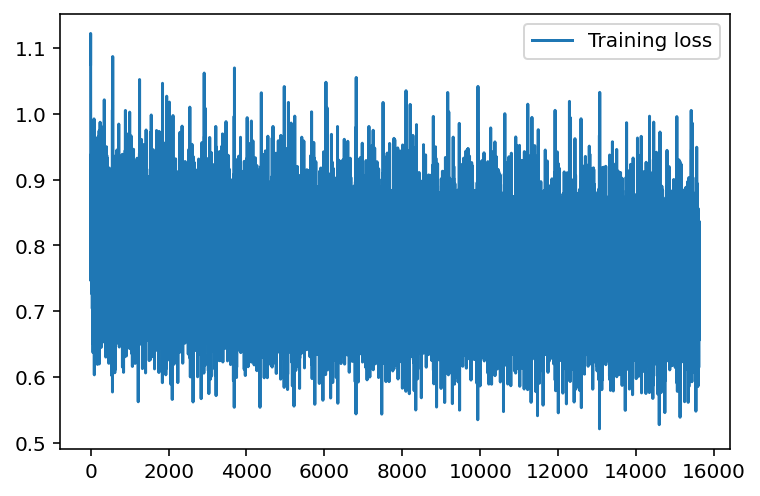

In [37]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(second_net.losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

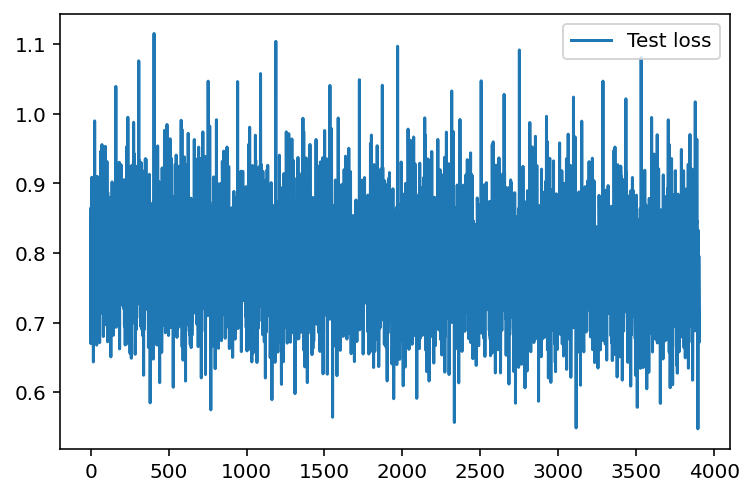

In [38]:
plt.plot(second_net.losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

### 7.1Generate movie feature matrix

In [42]:
movie_layer_model = keras.models.Model(inputs=[second_net.model.input[4], second_net.model.input[5], second_net.model.input[6]], 
                                 outputs=second_net.model.obtain_layer("movie_combine_layer_flat").output)
movie_matrics = []

for item in movies.values:
    categories = np.zeros([1, 18])
    categories[0] = item.take(2)

    titles = np.zeros([1, sentences_size])
    titles[0] = item.take(1)

    movie_combine_layer_flat_val = movie_layer_model([np.reshape(item.take(0), [1, 1]), categories, titles])  
    movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

In [43]:
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

### 7.2 Generate muser feature matrix

In [47]:
user_layer_model = keras.models.Model(inputs=[second_net.model.input[0], second_net.model.input[1], second_net.model.input[2], second_net.model.input[3]], 
                                 outputs = second_net.model.obtain_layer("user_combine_layer_flat").output)
users_matrics = []

for item in users.values:

    user_combine_layer_flat_val = user_layer_model([np.reshape(item.take(0), [1, 1]), 
                                                    np.reshape(item.take(1), [1, 1]), 
                                                    np.reshape(item.take(2), [1, 1]), 
                                                    np.reshape(item.take(3), [1, 1])])  
    users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

In [48]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

### 7.3 recommend the same type movie 

In [53]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
   
    norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keepdims=True))
    normalized_movie_matrics = movie_matrics / norm_movie_matrics

    
    probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
    sim = (probs_similarity.numpy())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    print("you watch movie is {}".format(movies_orga[movieid2idx[movie_id_val]]))
    print("recommend you is")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orga[val])
        
    return results


In [54]:
recommend_same_type_movie(1401, 20)

you watch movie is [1401 'Ghosts of Mississippi (1996)' 'Drama']
recommend you is
2981
[3050 'Light It Up (1999)' 'Drama']
2891
[2960 'Beefcake (1999)' 'Drama']
2927
[2996 'Music of the Heart (1999)' 'Drama']
3645
[3714 "Clara's Heart (1988)" 'Drama']
446
[450 'With Honors (1994)' 'Comedy|Drama']


{446, 2891, 2927, 2981, 3645}

### 7.3 recommend user favorite movie

In [1]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    
    probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    
    print("recommend your favourite")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orga[val])

    return results

In [58]:
recommend_your_favorite_movie(234, 10)

recommend your favourite
2693
[2762 'Sixth Sense, The (1999)' 'Thriller']
523
[527 "Schindler's List (1993)" 'Drama|War']
2128
[2197 'Firelight (1997)' 'Drama']
49
[50 'Usual Suspects, The (1995)' 'Crime|Thriller']
1242
[1262 'Great Escape, The (1963)' 'Adventure|War']


{49, 523, 1242, 2128, 2693}

### 7.4 recommend other types movie

In [64]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):

    probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
    favorite_user_id = np.argsort(probs_user_favorite_similarity.numpy())[0][-top_k:]
    
    print("the movie you watch{}".format(movies_orga[movieid2idx[movie_id_val]]))
        
    print("the people who enjoy this movie is {}".format(users_orga[favorite_user_id-1]))
    probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
    probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())

    p = np.argmax(sim, 1)
    print("People who enjoyed watching this film also enjoyed watching other")

    if len(set(p)) < 5:
        results = set(p)
    else:
        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
    for val in (results):
        print(val)
        print(movies_orga[val])
        
    return results

In [65]:
recommend_other_favorite_movie(1401, 20)

the movie you watch[1401 'Ghosts of Mississippi (1996)' 'Drama']
the people who enjoy this movie is [[2338 'M' 45 17]
 [2267 'F' 56 13]
 [4200 'M' 45 7]
 [2950 'M' 18 0]
 [1815 'M' 1 1]
 [1069 'M' 25 20]
 [5050 'F' 18 4]
 [1855 'M' 18 4]
 [451 'M' 56 13]
 [371 'M' 18 4]
 [282 'M' 25 17]
 [4800 'M' 18 4]
 [100 'M' 35 17]
 [4754 'F' 18 0]
 [5861 'F' 50 1]
 [4673 'M' 35 16]
 [2696 'M' 25 7]
 [3901 'M' 18 14]
 [3978 'M' 35 13]
 [2154 'M' 25 12]]
People who enjoyed watching this film also enjoyed watching other
2128
[2197 'Firelight (1997)' 'Drama']
777
[787 'Gate of Heavenly Peace, The (1995)' 'Documentary']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']
2693
[2762 'Sixth Sense, The (1999)' 'Thriller']


{315, 777, 2128, 2693}